In [ ]:
# Mount Google Drive (run this cell and follow authorization prompt)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Import Libraries
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

#  Dataset paths
train_dir = "/content/drive/MyDrive/lean_guard1.v2i.folder/train"
val_dir = "/content/drive/MyDrive/lean_guard1.v2i.folder/valid"

#  Image settings
img_size = (256, 256)
batch_size = 32
num_classes = 2
#class_names = ['safe', 'prohibited']

# 📊 Data generators
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")
val_gen = datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")

# 📋 Get class names from the dataset
class_names = list(train_gen.class_indices.keys())  # Extract class names from 'train_gen'
print("Class Names: ", class_names)


# ⚖️ Compute class weights
labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# 🧠 Custom CNN Model
def create_custom_cnn():
    model = models.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 🧠 EfficientNet Model with Fine-tuning
def create_efficientnet():
    base_model = EfficientNetB0(include_top=False, input_shape=(256, 256, 3), weights='imagenet')
    base_model.trainable = True  # Fine-tune entire model
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 🚀 Train both models
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

custom_model = create_custom_cnn()
custom_model.fit(train_gen, validation_data=val_gen, epochs=30, class_weight=class_weights, callbacks=[early_stop])
custom_model.save("custom_model.keras")

eff_model = create_efficientnet()
eff_model.fit(train_gen, validation_data=val_gen, epochs=30, class_weight=class_weights, callbacks=[early_stop])
eff_model.save("efficientnet_model.keras")


Found 7806 images belonging to 2 classes.
Found 501 images belonging to 2 classes.
Class Names:  ['prohibited', 'safe']


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 1760s 7s/step - accuracy: 0.7186 - loss: 0.5529 - val_accuracy: 0.8443 - val_loss: 0.3881
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.8071 - loss: 0.4316 - val_accuracy: 0.8383 - val_loss: 0.3668
Epoch 3/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - accuracy: 0.8121 - loss: 0.4231 - val_accuracy: 0.8523 - val_loss: 0.3705
Epoch 4/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.8204 - loss: 0.4009 - val_accuracy: 0.8723 - val_loss: 0.2951
Epoch 5/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 34s 140ms/step - accuracy: 0.8364 - loss: 0.3738 - val_accuracy: 0.8882 - val_loss: 0.3008
Epoch 6/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 37s 151ms/step - accuracy: 0.8464 - loss: 0.3499 - val_accuracy: 0.8683 - val_loss: 0.3655
Epoch 7/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.8487 - loss: 0.3517 - val_accuracy: 0.8723 - val_loss: 0.3065
Epoch 8/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.8420 - loss: 0.

Found 337 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


337/337 ━━━━━━━━━━━━━━━━━━━━ 71s 209ms/step
337/337 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
✅ Best Threshold: 0.27 | F1 Score: 0.9060


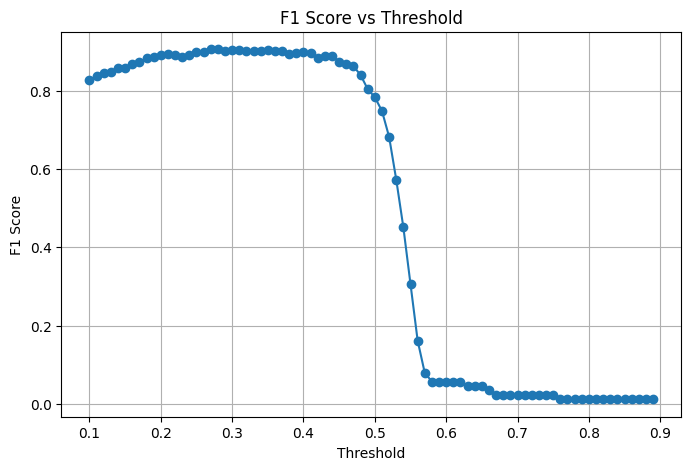


📋 Classification Report:
               precision    recall  f1-score   support

  prohibited       0.92      0.87      0.90       166
        safe       0.88      0.93      0.91       171

    accuracy                           0.90       337
   macro avg       0.90      0.90      0.90       337
weighted avg       0.90      0.90      0.90       337



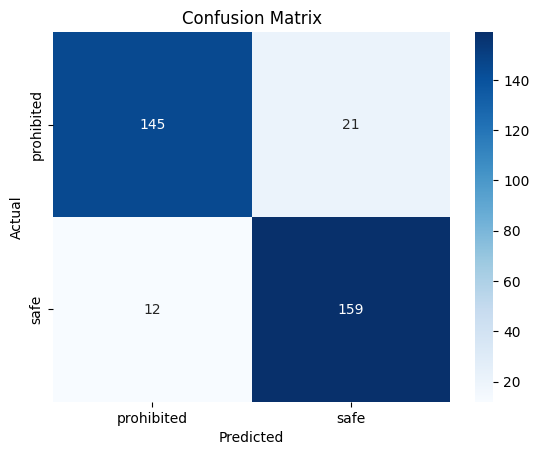

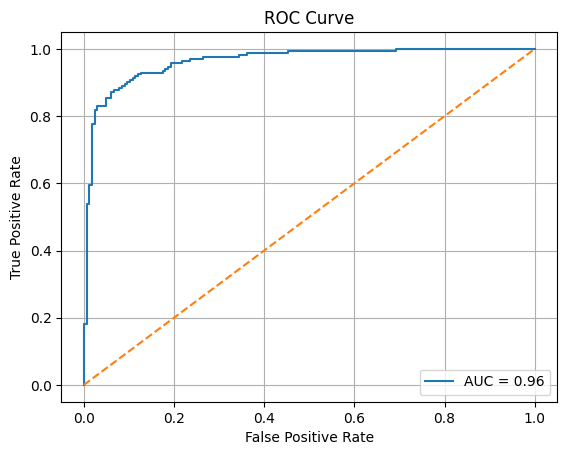

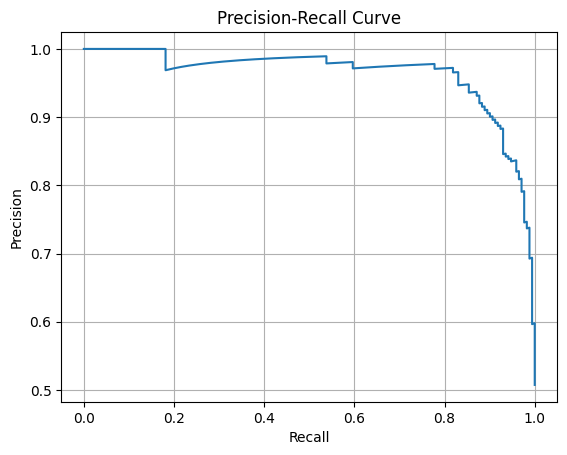

In [ ]:
# 🧪 Imports
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import load_model
import seaborn as sns

# 📁 Test dataset path
test_dir = "/content/drive/MyDrive/lean_guard1.v2i.folder/test"
test_gen = datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=1, class_mode='binary', shuffle=False)

# 📥 Load models
custom_model = load_model("custom_model.keras")
eff_model = load_model("efficientnet_model.keras")

# 🔮 Predict
preds_cnn = custom_model.predict(test_gen)
preds_eff = eff_model.predict(test_gen)

# 🧠 Ensemble predictions (average)
ensemble_preds = (preds_cnn + preds_eff) / 2
y_true = test_gen.classes

# 🔍 Threshold tuning
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_true, (ensemble_preds > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"✅ Best Threshold: {best_threshold:.2f} | F1 Score: {max(f1_scores):.4f}")

# 🎨 Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

# 📊 Final evaluation
y_pred_final = (ensemble_preds > best_threshold).astype(int)

print("\n📋 Classification Report:\n", classification_report(y_true, y_pred_final, target_names=class_names))

# 📌 Confusion Matrix
cm = confusion_matrix(y_true, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 📈 ROC Curve
fpr, tpr, _ = roc_curve(y_true, ensemble_preds)
roc_auc = roc_auc_score(y_true, ensemble_preds)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# ⚖️ Precision-Recall Curve
prec, recall, _ = precision_recall_curve(y_true, ensemble_preds)
plt.plot(recall, prec)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


In [ ]:
# 🔁 Reload the model
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/lean_guard1.v2i.folder/custom_model.keras")

# 💾 Re-save with compatible format (removes legacy issues like 'batch_shape')
model.save("/content/drive/MyDrive/lean_guard1.v2i.folder/custom_model_fixed.keras")


In [ ]:
eff_model = load_model("/content/drive/MyDrive/lean_guard1.v2i.folder/efficientnet_model.keras")
eff_model.save("/content/drive/MyDrive/lean_guard1.v2i.folder/efficientnet_model_fixed.keras")


Found 501 files belonging to 2 classes.
Found 337 files belonging to 2 classes.

Evaluating on Validation set...

Classification Report:
              precision    recall  f1-score   support

  prohibited       0.95      0.88      0.91       243
        safe       0.89      0.95      0.92       258

    accuracy                           0.92       501
   macro avg       0.92      0.92      0.92       501
weighted avg       0.92      0.92      0.92       501


Confusion Matrix:
[[214  29]
 [ 12 246]]


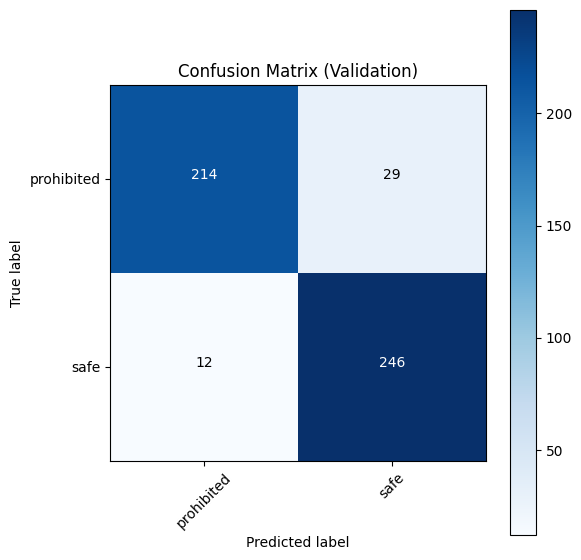


Evaluating on Test set...

Classification Report:
              precision    recall  f1-score   support

  prohibited       0.95      0.86      0.90       166
        safe       0.88      0.95      0.91       171

    accuracy                           0.91       337
   macro avg       0.91      0.91      0.91       337
weighted avg       0.91      0.91      0.91       337


Confusion Matrix:
[[143  23]
 [  8 163]]


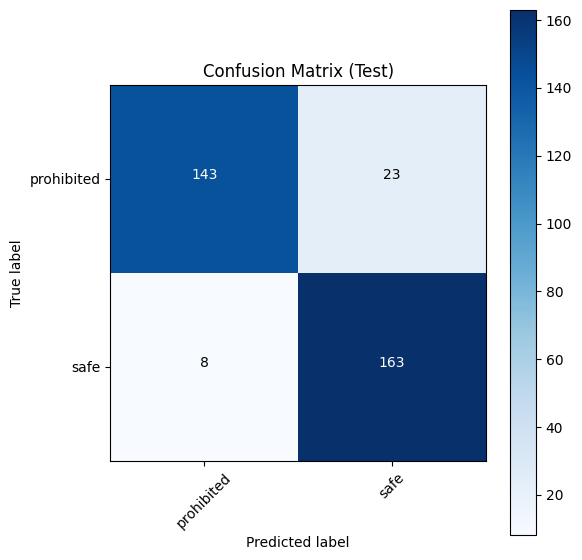

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import json
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

class ModelEvaluator:
    def __init__(self, model_path, metadata_path, data_dir):
        self.model = keras.models.load_model(model_path)
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        self.class_names = metadata['class_names']
        self.data_dir = data_dir
        self.optimal_threshold = 0.5  # You can adjust this based on your needs

    def load_datasets(self, img_size=(128, 128), batch_size=128):
        """Load validation and test datasets"""
        self.val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            f"{self.data_dir}/valid",
            image_size=img_size,
            batch_size=batch_size,
            shuffle=False
        ).prefetch(tf.data.AUTOTUNE)

        self.test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            f"{self.data_dir}/test",
            image_size=img_size,
            batch_size=batch_size,
            shuffle=False
        ).prefetch(tf.data.AUTOTUNE)

    def _get_predictions(self, dataset):
        """Helper method to get true labels and predictions"""
        y_true = []
        y_pred = []

        for images, labels in dataset:
            y_true.extend(labels.numpy())
            y_pred.extend(self.model.predict(images, verbose=0).flatten())

        return np.array(y_true), np.array(y_pred)

    def evaluate_dataset(self, dataset, dataset_name):
        """Evaluate model on a specific dataset"""
        print(f"\nEvaluating on {dataset_name} set...")

        # Get predictions
        y_true, y_pred = self._get_predictions(dataset)
        y_pred_classes = (y_pred > self.optimal_threshold).astype(int)

        # Calculate and print metrics
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes, target_names=self.class_names))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)
        print("\nConfusion Matrix:")
        print(cm)

        # Plot confusion matrix
        self.plot_confusion_matrix(cm, f"Confusion Matrix ({dataset_name})")

        return y_true, y_pred

    def plot_confusion_matrix(self, cm, title):
        """Plot confusion matrix"""
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names)

        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

# Configuration - Update these paths to match your environment
CONFIG = {
    "model_path": "/content/drive/MyDrive/lean_guard_model_package/model.keras",
    "metadata_path": "/content/drive/MyDrive/lean_guard_model_package/metadata.json",
    "data_dir": "/content/drive/MyDrive/lean_guard1.v2i.folder"
}

if __name__ == "__main__":
    # Initialize evaluator
    evaluator = ModelEvaluator(
        model_path=CONFIG["model_path"],
        metadata_path=CONFIG["metadata_path"],
        data_dir=CONFIG["data_dir"]
    )

    # Load datasets
    evaluator.load_datasets()

    # Evaluate on validation set
    val_true, val_pred = evaluator.evaluate_dataset(evaluator.val_ds, "Validation")

    # Evaluate on test set
    test_true, test_pred = evaluator.evaluate_dataset(evaluator.test_ds, "Test")

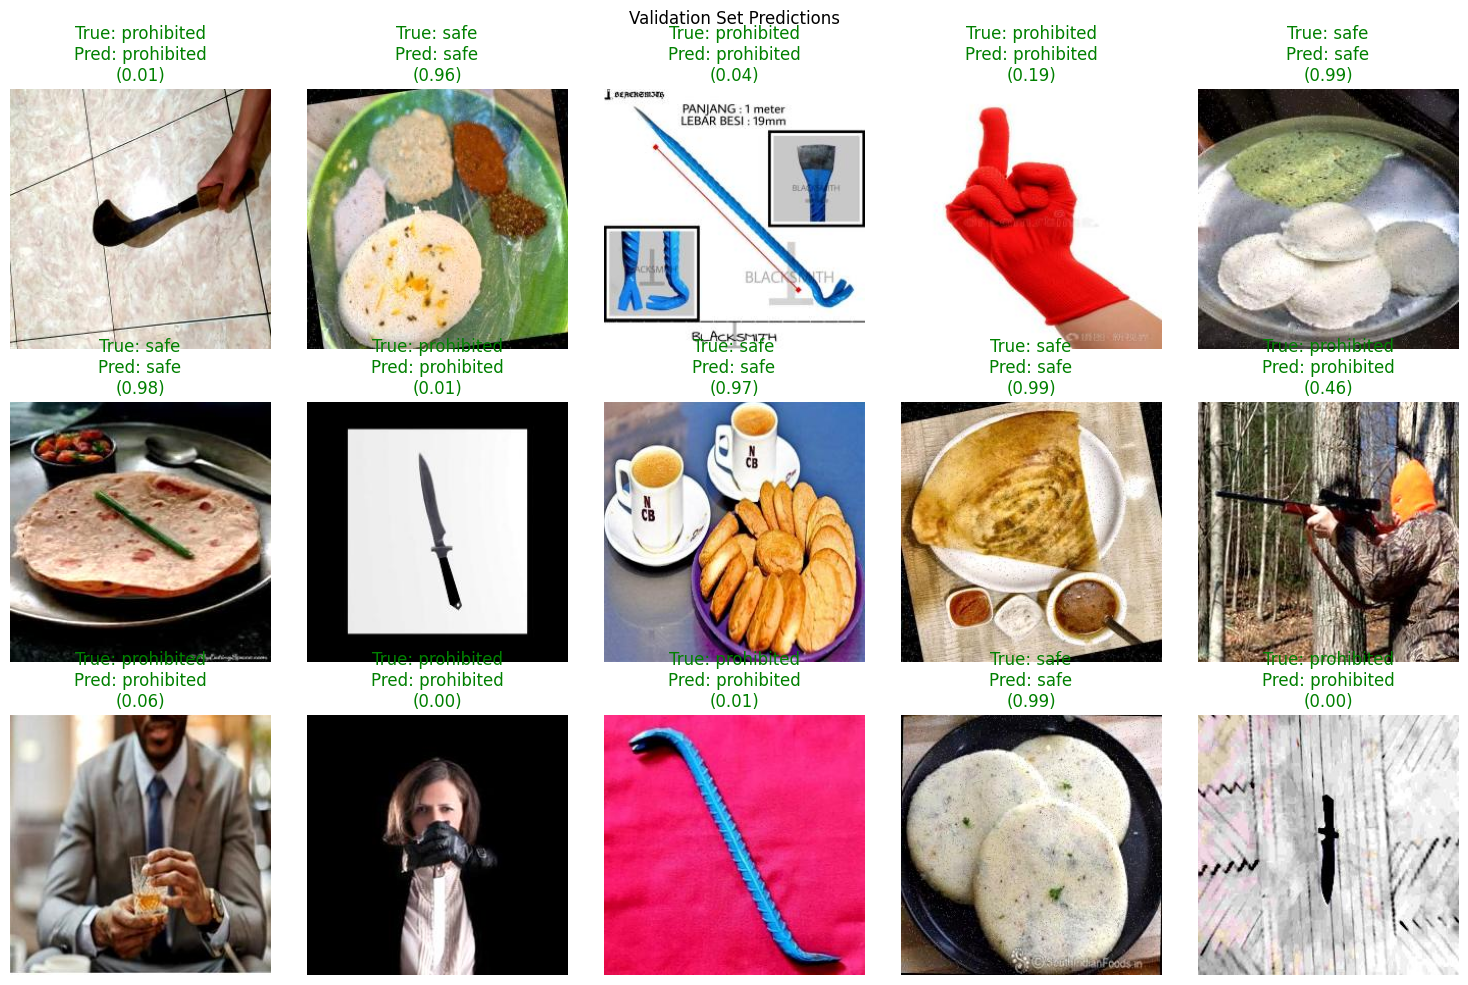


Prediction Statistics for Validation Set:
Accuracy: 100.00% (15/15)

Detailed Predictions:
Image: celurit-298-_jpg.rf.27db7fd03419b6b5cc6f6ec43b81f256.jpg
  True: prohibited, Predicted: prohibited
  Confidence: 0.0089
  ✓ Correct

Image: thatte_idli-15-_jpg.rf.d94ec3c09bf5154e52ccd166fa2f8c3d.jpg
  True: safe, Predicted: safe
  Confidence: 0.9637
  ✓ Correct

Image: Linggis-209-_jpg.rf.e1af722ff6f69315e50f04883b17d277.jpg
  True: prohibited, Predicted: prohibited
  Confidence: 0.0385
  ✓ Correct

Image: 5e89603db960a511770e0b9abcd5ef8b_jpeg_jpg.rf.beacdf2e2acafd9fe9939c7bf31dc2f0.jpg
  True: prohibited, Predicted: prohibited
  Confidence: 0.1911
  ✓ Correct

Image: idly-39-_jpg.rf.2ec88cab68b64bb5428d674a2ac1bbae.jpg
  True: safe, Predicted: safe
  Confidence: 0.9920
  ✓ Correct

Image: chappati23_jpg.rf.40872e079e409172e60709b06af848af.jpg
  True: safe, Predicted: safe
  Confidence: 0.9794
  ✓ Correct

Image: knife_4_29_png_jpg.rf.f64d51302477973caf101d16dbdf19ba.jpg
  True: prohibit

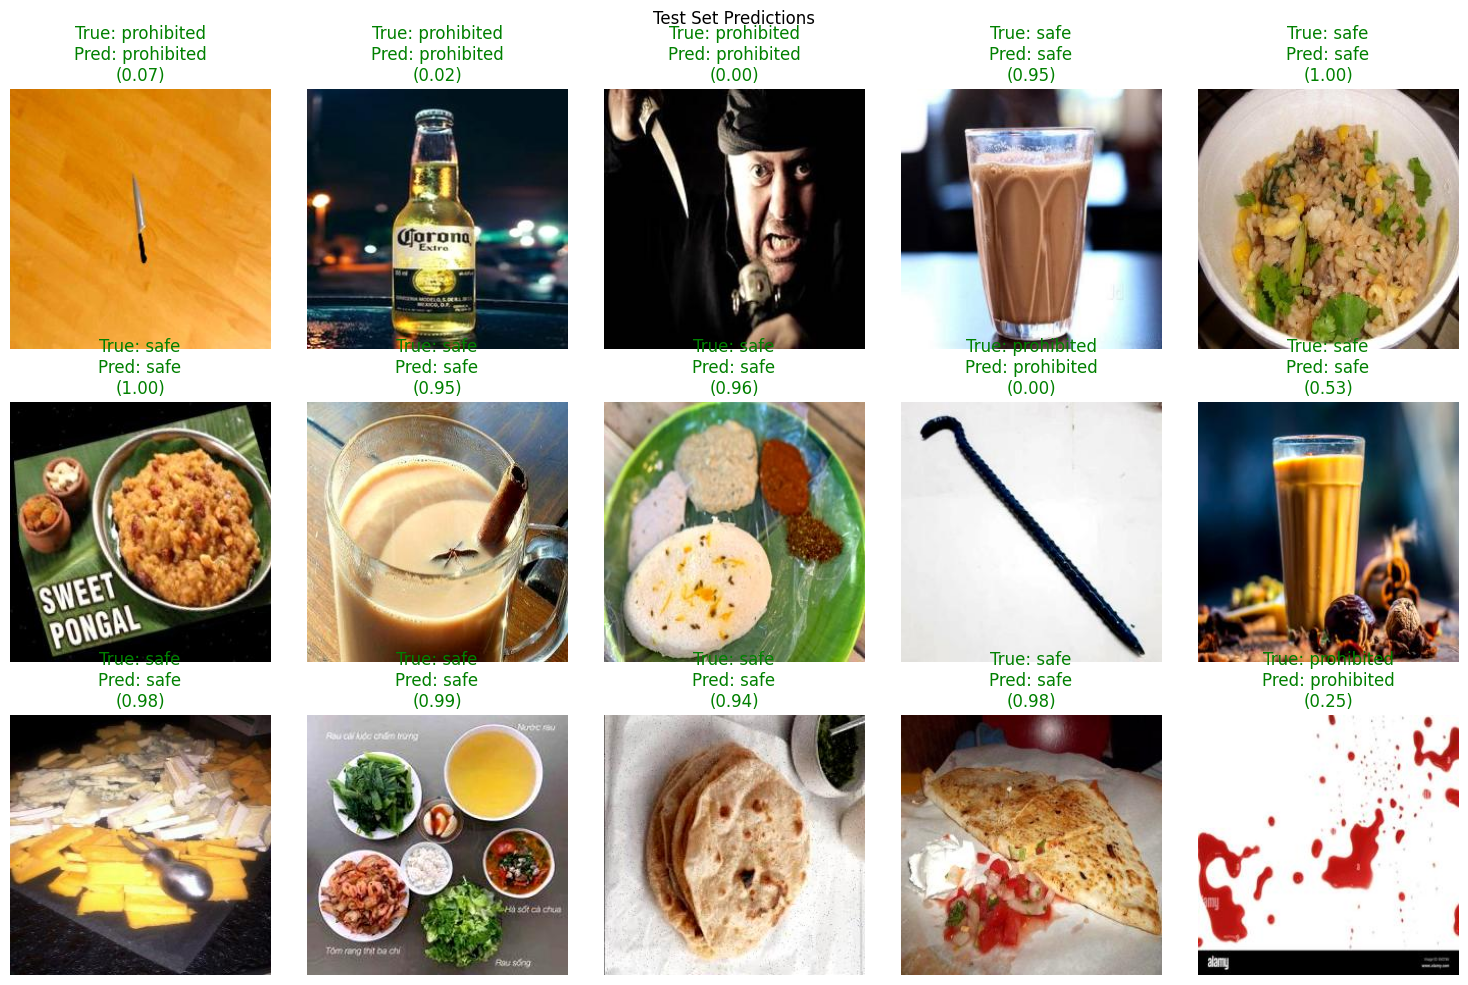


Prediction Statistics for Test Set:
Accuracy: 100.00% (15/15)

Detailed Predictions:
Image: knife_1_10_png_jpg.rf.865a76903182fd5bec405c9618ddff57.jpg
  True: prohibited, Predicted: prohibited
  Confidence: 0.0736
  ✓ Correct

Image: img_hod_004486_jpg.rf.ad7712d75e585476498113ab436889f5.jpg
  True: prohibited, Predicted: prohibited
  Confidence: 0.0248
  ✓ Correct

Image: img_hod_002285_jpg.rf.d7350b8db708e87b6976c28d0a53923c.jpg
  True: prohibited, Predicted: prohibited
  Confidence: 0.0000
  ✓ Correct

Image: 292_jpg.rf.0b46ce6533a8fa0aa9da27bc709c39c6.jpg
  True: safe, Predicted: safe
  Confidence: 0.9476
  ✓ Correct

Image: 145_jpg.rf.4f2f962ea04a53569cf7d3f9b42dce96.jpg
  True: safe, Predicted: safe
  Confidence: 0.9985
  ✓ Correct

Image: venpongal-14-_jpg.rf.1b6685dc368413bec6b2ee97d63d2ff7.jpg
  True: safe, Predicted: safe
  Confidence: 0.9991
  ✓ Correct

Image: 105_jpg.rf.043b475d4aec2ecaea238c0fd1746489.jpg
  True: safe, Predicted: safe
  Confidence: 0.9517
  ✓ Correct

Im

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import json
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

class ModelPredictor:
    def __init__(self, model_path, metadata_path, data_dir):
        self.model = keras.models.load_model(model_path)
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        self.class_names = metadata['class_names']
        self.data_dir = data_dir
        self.optimal_threshold = 0.5
        self.img_size = (128, 128)

    def load_random_images(self, subset='test', num_images=15):
        """Load random images from a specified subset (test or valid)"""
        subset_dir = os.path.join(self.data_dir, subset)
        all_images = []

        # Collect all image paths
        for class_name in self.class_names:
            class_dir = os.path.join(subset_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_images.append((os.path.join(class_dir, img_file), class_name))

        # Select random images
        selected = random.sample(all_images, min(num_images, len(all_images)))
        return selected

    def preprocess_image(self, image_path):
        """Load and preprocess a single image"""
        img = keras.preprocessing.image.load_img(
            image_path,
            target_size=self.img_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
        return img_array

    def predict_images(self, image_paths):
        """Make predictions on a list of images"""
        predictions = []
        for img_path, true_class in image_paths:
            img_array = self.preprocess_image(img_path)
            pred_prob = float(self.model.predict(img_array, verbose=0)[0][0])
            pred_class = self.class_names[1] if pred_prob > self.optimal_threshold else self.class_names[0]
            predictions.append({
                'image_path': img_path,
                'true_class': true_class,
                'pred_prob': pred_prob,
                'pred_class': pred_class,
                'correct': true_class == pred_class
            })
        return predictions

    def visualize_predictions(self, predictions, title):
        """Display images with their predictions"""
        plt.figure(figsize=(15, 10))
        for i, pred in enumerate(predictions):
            plt.subplot(3, 5, i+1)
            img = keras.preprocessing.image.load_img(pred['image_path'])
            plt.imshow(img)

            # Set title color based on prediction correctness
            title_color = 'green' if pred['correct'] else 'red'
            plt.title(f"True: {pred['true_class']}\nPred: {pred['pred_class']}\n({pred['pred_prob']:.2f})",
                     color=title_color)
            plt.axis('off')
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    def print_prediction_stats(self, predictions, subset_name):
        """Print statistics about predictions"""
        correct = sum(1 for p in predictions if p['correct'])
        total = len(predictions)
        accuracy = correct / total

        print(f"\nPrediction Statistics for {subset_name}:")
        print(f"Accuracy: {accuracy:.2%} ({correct}/{total})")
        print("\nDetailed Predictions:")
        for pred in predictions:
            print(f"Image: {os.path.basename(pred['image_path'])}")
            print(f"  True: {pred['true_class']}, Predicted: {pred['pred_class']}")
            print(f"  Confidence: {pred['pred_prob']:.4f}")
            print(f"  {'✓ Correct' if pred['correct'] else '✗ Incorrect'}\n")

# Configuration - Update these paths to match your environment
CONFIG = {
    "model_path": "/content/drive/MyDrive/lean_guard_model_package/model.keras",
    "metadata_path": "/content/drive/MyDrive/lean_guard_model_package/metadata.json",
    "data_dir": "/content/drive/MyDrive/lean_guard1.v2i.folder"
}

if __name__ == "__main__":
    # Initialize predictor
    predictor = ModelPredictor(
        model_path=CONFIG["model_path"],
        metadata_path=CONFIG["metadata_path"],
        data_dir=CONFIG["data_dir"]
    )

    # Test on validation set
    val_images = predictor.load_random_images(subset='valid', num_images=15)
    val_predictions = predictor.predict_images(val_images)
    predictor.visualize_predictions(val_predictions, "Validation Set Predictions")
    predictor.print_prediction_stats(val_predictions, "Validation Set")

    # Test on test set
    test_images = predictor.load_random_images(subset='test', num_images=15)
    test_predictions = predictor.predict_images(test_images)
    predictor.visualize_predictions(test_predictions, "Test Set Predictions")
    predictor.print_prediction_stats(test_predictions, "Test Set")

In [ ]:
import sys
import tensorflow as tf

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
TensorFlow version: 2.18.0
